### TP3: Autoencoders

Libraries Import

In [16]:
import numpy                as np
import matplotlib.pyplot    as plt
import pandas               as pd
import tensorflow           as tf
import pydot
from tensorflow             import keras
from keras.models           import Model
from keras.layers           import Input, Dense
from keras.utils            import plot_model

Data Import and preparation

In [17]:
df=pd.read_csv('us_equities_logreturns_cut.csv') #change path accordingly

In [18]:
df=df.dropna(axis=1)
df.drop('Unnamed: 0',axis='columns',inplace=True)
#df.head()

In [19]:
X=df.to_numpy().transpose()
#X

In [20]:
#For question 1, assets are rows and time is coloumns
#Data divised as follows : 60% Training, 20% Validation, 20% Test 

Nb_assets=X.shape[0]

Train_data_size= int(0.6*Nb_assets)
Validation_data_size =int(0.2*Nb_assets)
Test_data_size=Nb_assets-(Train_data_size+Validation_data_size)

Train_data=X[:Train_data_size,:]
Validation_data=X[Train_data_size+1 : Train_data_size+ Validation_data_size,:]
Test_data=X[Train_data_size+Validation_data_size+1 :,:]

In [21]:
#For question 2, time is rows and assets are coloumns
#Data divised as follows : 60% Training, 20% Validation, 20% Test 

Y=X.transpose()
Nb_days=Y.shape[0]

Train_data_size_2= int(0.6*Nb_days)
Validation_data_size_2 =int(0.2*Nb_days)
Test_data_size_2=Nb_days-(Train_data_size_2+Validation_data_size_2)

Train_data_2=Y[:Train_data_size_2,:]
Validation_data_2=Y[Train_data_size_2+1 : Train_data_size_2+ Validation_data_size_2,:]
Test_data_2=Y[Train_data_size_2+Validation_data_size_2+1 :,:]

Functions Definition

In [22]:
def build_AE(D, B, loss, act, L1_eps=0):
    
    M=int(D+B/2) # Intermediate will be of szie M so that dimensionality reduction is gradual

    inputs = Input(shape=(D,))

    encoder = Dense(M, activation=act, kernel_regularizer=tf.keras.regularizers.l1(L1_eps))(inputs)

    bottleneck = Dense(B, activation=act)(encoder)

    decoder = Dense(M, activation=act, kernel_regularizer=tf.keras.regularizers.l1(L1_eps))(bottleneck)

    outputs = Dense(D, activation='linear', kernel_regularizer=tf.keras.regularizers.l1(L1_eps))(decoder)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss, optimizer='adam')

    return inputs, encoder, bottleneck, model

In [23]:
# We have to be carefull with the activation function that use in the previous code, particularly Relu would only allow positive values for the output layer which
# problematic as returns can be negative, that's why i chose to fix the activation function for the output layer to linear.

In [24]:
#Calculating the fraction of correctly predicted signs of returns
def Correct_sign_fract(D, B, loss, activation, L1_eps,set='Train_data',question=1):

    inputs, encoder, bottleneck, model = build_AE(D, B, loss, activation, L1_eps)
    
    if question == 1:
        model.fit(Train_data, Train_data, epochs=30, batch_size=64)
    if question == 2:
        model.fit(Train_data_2, Train_data_2, epochs=30, batch_size=64)


    if set=='Train_data':

        if question == 1:
            Predicted_data = model.predict(Train_data)
            Fract_sign=np.mean(np.sign(Predicted_data)==np.sign(Train_data))

        if question == 2:
            Predicted_data = model.predict(Train_data_2)
            Fract_sign=np.mean(np.sign(Predicted_data)==np.sign(Train_data_2))

    if set=='Validation_data':

        if question == 1:
            Predicted_data = model.predict(Validation_data)
            Fract_sign=np.mean(np.sign(Predicted_data)==np.sign(Validation_data))

        if question == 2:
            Predicted_data = model.predict(Validation_data_2)
            Fract_sign=np.mean(np.sign(Predicted_data)==np.sign(Validation_data_2))

    if set=='Test_data':

        if question == 1:
            Predicted_data = model.predict(Test_data)
            Fract_sign=np.mean(np.sign(Predicted_data)==np.sign(Test_data))

        if question == 2:
            Predicted_data = model.predict(Test_data_2)
            Fract_sign=np.mean(np.sign(Predicted_data)==np.sign(Test_data_2))

    
    return Fract_sign

In [25]:
#Plotting the fraction of correctly predicted signs of returns as a function of B
def Correct_sign_fract_plot(D, B_range, loss, activation, L1_eps,set='Train_data',question=1):

    Fract_signs={'Train_data':[],
                 'Validation_data':[],
                 'Test_data':[]}
    
    for B in B_range:
        Fract_sign=Correct_sign_fract(D, B, loss, activation, L1_eps,set='Train_data',question=question)
        Fract_signs['Train_data'].append(Fract_sign)

        Fract_sign=Correct_sign_fract(D, B, loss, activation, L1_eps,set='Validation_data',question=question)
        Fract_signs['Validation_data'].append(Fract_sign)

        Fract_sign=Correct_sign_fract(D, B, loss, activation, L1_eps,set='Test_data',question=question)
        Fract_signs['Test_data'].append(Fract_sign)

    fig, axs = plt.subplots(1,3,figsize=(24,6))
    fig.suptitle(r'Correct prediction of sign(r_i(t)) as a function of B')

    axs[0].set_title(r'In the Training data')
    axs[1].set_title(r'In the Validation data')
    axs[2].set_title(r'In the Test data')

    axs[0].plot(B_range,Fract_signs['Train_data'])
    axs[1].plot(B_range,Fract_signs['Validation_data'])
    axs[2].plot(B_range,Fract_signs['Test_data'])

    for i in [0,1,2]:
        axs[i].set_xlabel(r'B')
        axs[i].set_ylabel(r'Correct fraction of r_i(t)')
    axs[1].legend()
    plt.show()

In [37]:
#Plotting the lattent state z2 as a function of the latent state z1
def Latent_states_plot(D,loss, activation, L1_eps,B=2, question=1):
    
    z1,z2=[],[]

    inputs, encoder, bottleneck, model = build_AE(D, B, loss, activation, L1_eps)

    if question == 1:
        model.fit(Train_data, Train_data, epochs=30, batch_size=64)
        bottleneck_model = Model(inputs=inputs, outputs=bottleneck)
        Latent_states = bottleneck_model.predict(Train_data)
        
    if question ==2:
        model.fit(Train_data_2, Train_data_2, epochs=30, batch_size=64)
        bottleneck_model = Model(inputs=inputs, outputs=bottleneck)
        Latent_states = bottleneck_model.predict(Train_data_2)

    for i in range(Latent_states.shape[0]):
        z1.append(Latent_states[i,0])
        z2.append(Latent_states[i,1])

    plt.scatter(z1,z2)
    plt.title('Latent state z_i_2 as a function of Latent state z_i_1')
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.grid()
    plt.show()

Q1) categorisation of assets

In [27]:
N,T = Train_data.shape
B = 2
B_range=np.arange(2,15)
loss = 'mse'
activation = 'tanh'  
L1_eps = 0 #no regularisation for the moment  

In [28]:
'''inputs, encoder, bottleneck, model = build_AE(N, B, loss, activation, L1_eps)
plot_model(model, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)'''

"inputs, encoder, bottleneck, model = build_AE(N, B, loss, activation, L1_eps)\nplot_model(model, to_file='autoencoder.png', show_shapes=True, show_layer_names=True)"

Epoch 1/30


3/3 [==============================] - 4s 592ms/step - loss: 5.1993e-04
Epoch 2/30
3/3 [==============================] - 2s 532ms/step - loss: 4.6264e-04
Epoch 3/30
3/3 [==============================] - 2s 639ms/step - loss: 4.2377e-04
Epoch 4/30
3/3 [==============================] - 2s 575ms/step - loss: 4.0047e-04
Epoch 5/30
3/3 [==============================] - 2s 546ms/step - loss: 3.9036e-04
Epoch 6/30
3/3 [==============================] - 2s 561ms/step - loss: 3.8923e-04
Epoch 7/30
3/3 [==============================] - 2s 560ms/step - loss: 3.9121e-04
Epoch 8/30
3/3 [==============================] - 2s 578ms/step - loss: 3.9136e-04
Epoch 9/30
3/3 [==============================] - 2s 553ms/step - loss: 3.8940e-04
Epoch 10/30
3/3 [==============================] - 2s 562ms/step - loss: 3.8634e-04
Epoch 11/30
3/3 [==============================] - 2s 551ms/step - loss: 3.8467e-04
Epoch 12/30
3/3 [==============================] - 2s 644ms/step - loss: 3.8414e-04
Epoch 13/30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


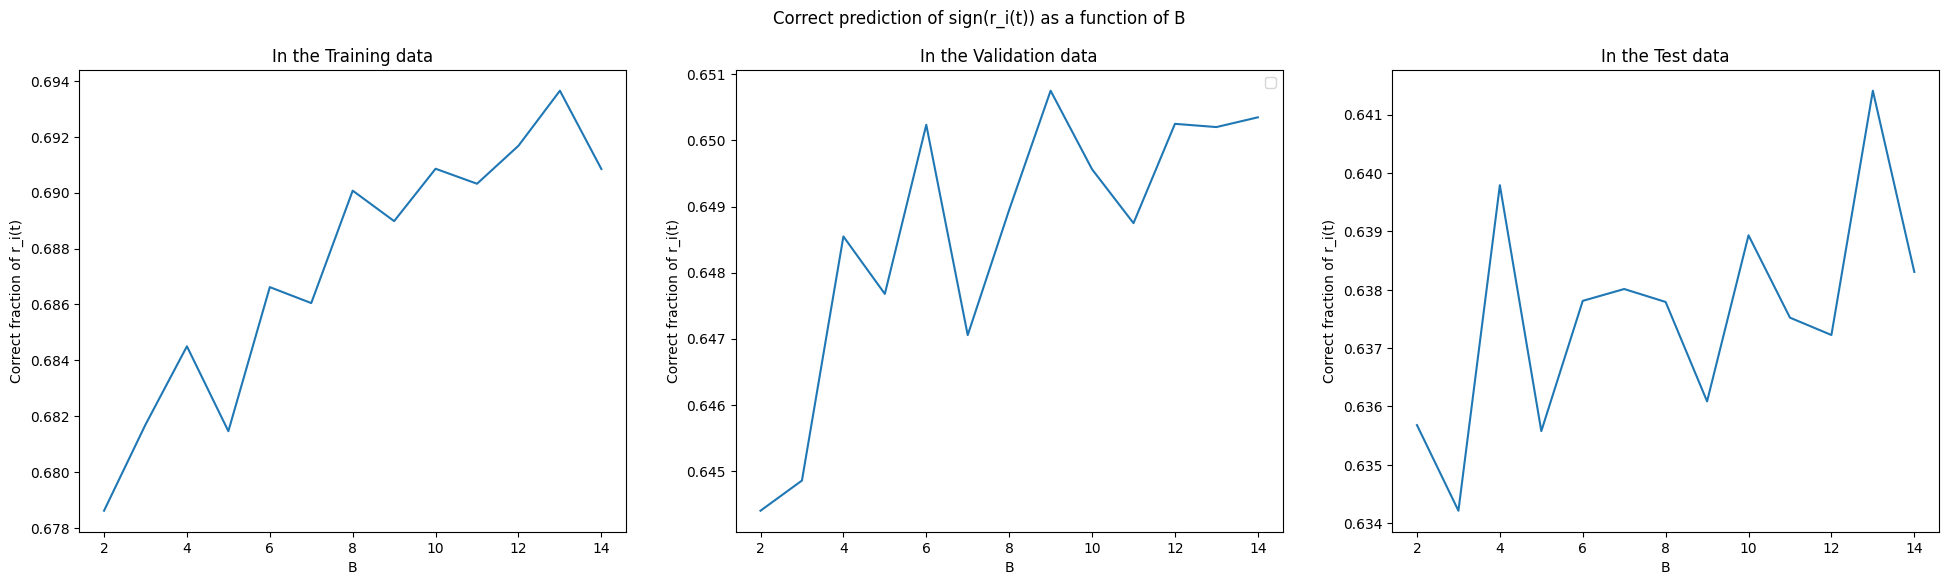

In [29]:
Correct_sign_fract_plot(T, B_range, loss, activation, L1_eps,set='Train_data',question=1)

- The increasing tendancy of the correctly predicted return signs as a function of B is quite logical (the greater the bottleneck space the less information is sacrificed)
- The fractions are better in the training data which is to be expected
- fraction of order ~0.64 in the test set are acceptable but not that great, actually this result gets affected by the activation function used in the Auto Encoder and even decreased to ~0.5 when sigmoid was used. This suggests that possibly using other combinations of activation functions might improve results

Epoch 1/30
3/3 [==============================] - 4s 583ms/step - loss: 5.2032e-04
Epoch 2/30
3/3 [==============================] - 2s 605ms/step - loss: 4.6223e-04
Epoch 3/30
3/3 [==============================] - 2s 656ms/step - loss: 4.2445e-04
Epoch 4/30
3/3 [==============================] - 2s 672ms/step - loss: 4.0173e-04
Epoch 5/30
3/3 [==============================] - 2s 655ms/step - loss: 3.9122e-04
Epoch 6/30
3/3 [==============================] - 2s 612ms/step - loss: 3.8846e-04
Epoch 7/30
3/3 [==============================] - 2s 583ms/step - loss: 3.8930e-04
Epoch 8/30
3/3 [==============================] - 2s 594ms/step - loss: 3.8892e-04
Epoch 9/30
3/3 [==============================] - 2s 591ms/step - loss: 3.8639e-04
Epoch 10/30
3/3 [==============================] - 2s 631ms/step - loss: 3.8333e-04
Epoch 11/30
3/3 [==============================] - 2s 617ms/step - loss: 3.8007e-04
Epoch 12/30
3/3 [==============================] - 2s 612ms/step - loss: 3.7708e-04
E

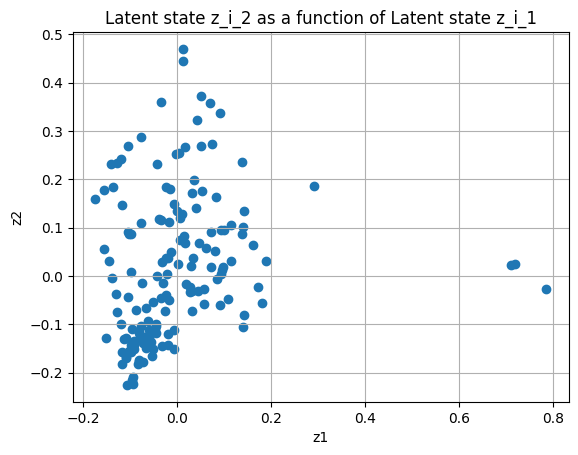

In [38]:
Latent_states_plot(T,loss, activation, L1_eps,B=2, question=1)

Q2) Etat du marché

Epoch 1/30
39/39 [==============================] - 2s 6ms/step - loss: 4.9575e-04
Epoch 2/30
39/39 [==============================] - 0s 5ms/step - loss: 4.1830e-04
Epoch 3/30
39/39 [==============================] - 0s 5ms/step - loss: 4.0918e-04
Epoch 4/30
39/39 [==============================] - 0s 6ms/step - loss: 4.0851e-04
Epoch 5/30
39/39 [==============================] - 0s 7ms/step - loss: 4.0817e-04
Epoch 6/30
39/39 [==============================] - 0s 8ms/step - loss: 4.0811e-04
Epoch 7/30
39/39 [==============================] - 0s 7ms/step - loss: 4.0798e-04
Epoch 8/30
39/39 [==============================] - 0s 7ms/step - loss: 4.0825e-04
Epoch 9/30
39/39 [==============================] - 0s 7ms/step - loss: 4.0798e-04
Epoch 10/30
39/39 [==============================] - 0s 6ms/step - loss: 4.0760e-04
Epoch 11/30
39/39 [==============================] - 0s 7ms/step - loss: 4.0789e-04
Epoch 12/30
39/39 [==============================] - 0s 7ms/step - loss: 4.0794e-04
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


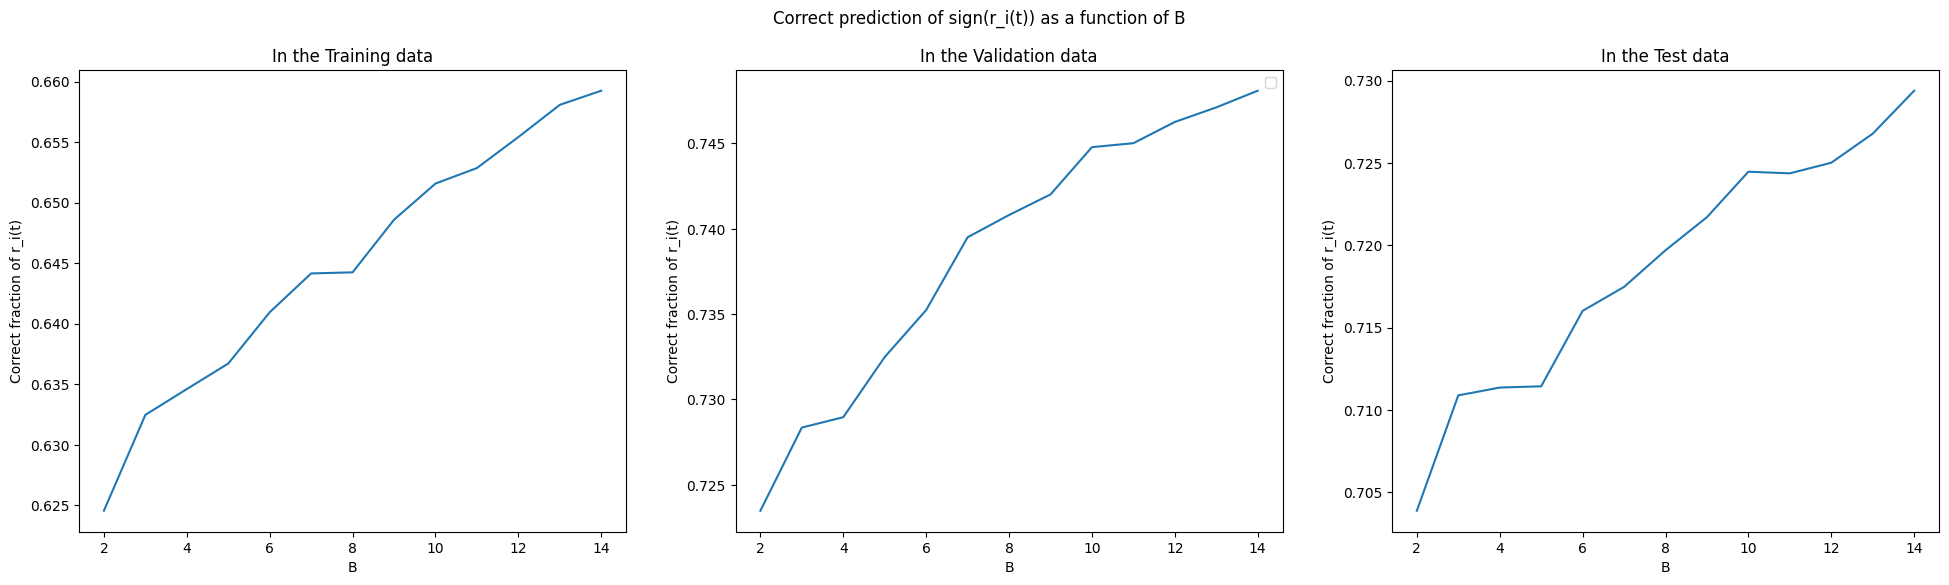

In [31]:
Correct_sign_fract_plot(Train_data_2.shape[1], B_range, loss, activation, L1_eps,set='Train_data',question=2)

Like in the previous
- The increasing tendancy of the correctly predicted return signs as a function of B is quite logical (the greater the bottleneck space the less information is sacrificed)
- Counterintuatively The fractions are better in the Test than in the training data
- fraction are of order ~0.72 in the test set which is better than in the other case (lines are asstes column is time)

Interestingly we can predict the returns better just by inverting the training data which is a bit curious. considering that our data is a set of returns of different assets for a single moment seems to provide better result than considering our data as a set of returns for a single asset during a certain period. 
This might suggest that it is easier to predict the market state for a single moment than to predict the returns of one asset on a long time. 

Epoch 1/30
39/39 [==============================] - 2s 5ms/step - loss: 5.0908e-04
Epoch 2/30
39/39 [==============================] - 0s 5ms/step - loss: 4.2731e-04
Epoch 3/30
39/39 [==============================] - 0s 5ms/step - loss: 4.1532e-04
Epoch 4/30
39/39 [==============================] - 0s 5ms/step - loss: 4.1266e-04
Epoch 5/30
39/39 [==============================] - 0s 5ms/step - loss: 4.1107e-04
Epoch 6/30
39/39 [==============================] - 0s 5ms/step - loss: 4.0931e-04
Epoch 7/30
39/39 [==============================] - 0s 5ms/step - loss: 4.0843e-04
Epoch 8/30
39/39 [==============================] - 0s 6ms/step - loss: 4.0801e-04
Epoch 9/30
39/39 [==============================] - 0s 6ms/step - loss: 4.0803e-04
Epoch 10/30
39/39 [==============================] - 0s 6ms/step - loss: 4.0777e-04
Epoch 11/30
39/39 [==============================] - 0s 5ms/step - loss: 4.0765e-04
Epoch 12/30
39/39 [==============================] - 0s 5ms/step - loss: 4.0768e-04
E

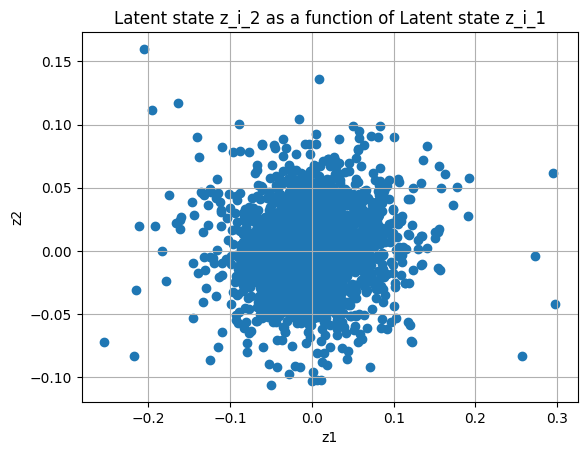

In [39]:
Latent_states_plot(Train_data_2.shape[1],loss, activation, L1_eps,B=2, question=2)

It looks like the latent variables are uncorrelated (the plot is similar to 2D- random normal vector), data can be represented by two uncorrelated variables 

Q3) Anomaly Detection

Error as a function of time 

In [33]:
B=3
inputs, encoder, bottleneck, model = build_AE(Train_data_2.shape[1], B, loss, activation, L1_eps)
model.fit(Train_data_2, Train_data_2, epochs=100, batch_size=64)
Predicted_data = model.predict(Train_data_2)

Epoch 1/100
39/39 [==============================] - 2s 5ms/step - loss: 4.8812e-04
Epoch 2/100
39/39 [==============================] - 0s 5ms/step - loss: 4.1459e-04
Epoch 3/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9960e-04
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9463e-04
Epoch 5/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9383e-04
Epoch 6/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9352e-04
Epoch 7/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9316e-04
Epoch 8/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9329e-04
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9315e-04
Epoch 10/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9332e-04
Epoch 11/100
39/39 [==============================] - 0s 5ms/step - loss: 3.9305e-04
Epoch 12/100
39/39 [==============================] - 0s 5ms/step - loss: 

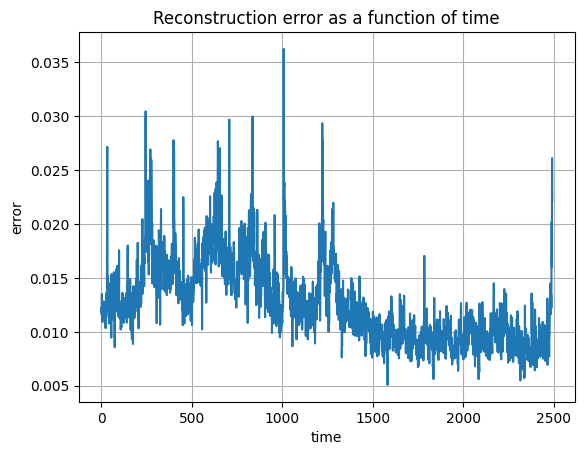

In [34]:
Fract_sign=np.mean(np.abs(Predicted_data-Train_data_2),axis=1)
plt.plot(Fract_sign)
plt.title('Reconstruction error as a function of time')
plt.xlabel('time')
plt.ylabel('error')
plt.grid()
plt.show()

Error per asset

In [35]:
B=3
inputs, encoder, bottleneck, model = build_AE(T, B, loss, activation, L1_eps)
model.fit(Train_data, Train_data, epochs=100, batch_size=32, shuffle=True)
Predicted_data = model.predict(Train_data)

Epoch 1/100
5/5 [==============================] - 5s 550ms/step - loss: 4.9923e-04
Epoch 2/100
5/5 [==============================] - 3s 572ms/step - loss: 4.2567e-04
Epoch 3/100
5/5 [==============================] - 3s 599ms/step - loss: 3.9444e-04
Epoch 4/100
5/5 [==============================] - 3s 579ms/step - loss: 3.9006e-04
Epoch 5/100
5/5 [==============================] - 3s 610ms/step - loss: 3.9041e-04
Epoch 6/100
5/5 [==============================] - 3s 583ms/step - loss: 3.8758e-04
Epoch 7/100
5/5 [==============================] - 3s 639ms/step - loss: 3.8412e-04
Epoch 8/100
5/5 [==============================] - 3s 619ms/step - loss: 3.8195e-04
Epoch 9/100
5/5 [==============================] - 3s 586ms/step - loss: 3.7829e-04
Epoch 10/100
5/5 [==============================] - 3s 628ms/step - loss: 3.7140e-04
Epoch 11/100
5/5 [==============================] - 3s 625ms/step - loss: 3.6341e-04
Epoch 12/100
5/5 [==============================] - 3s 625ms/step - loss: 

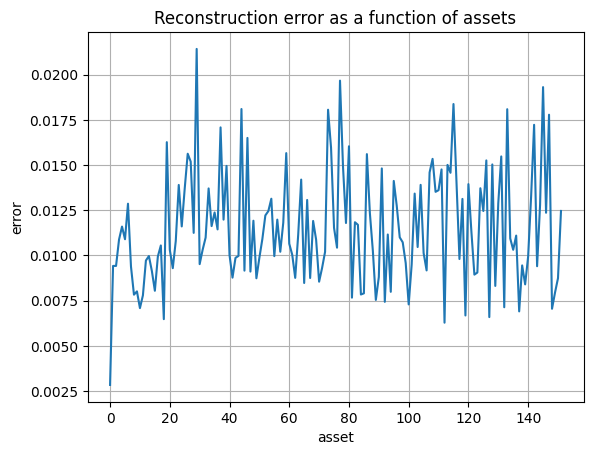

In [40]:
Fract_sign=np.mean(np.abs(Predicted_data-Train_data),axis=1)
plt.plot(Fract_sign)
plt.title('Reconstruction error as a function of assets')
plt.xlabel('asset')
plt.ylabel('error')
plt.grid()
plt.show()